In [12]:
import urllib
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import math

%matplotlib notebook

cache = {}

def get_data(country):
    url = "https://en.wikipedia.org/w/index.php?title=Template:2019%%E2%%80%%9320_coronavirus_outbreak_data/%s_medical_cases_chart&action=raw" % country
    if url not in cache:
        data = urllib.request.urlopen(url).read()    
        ret = str(data, "utf8")
        cache[url] = ret
    return cache[url]


def postprocess(e, deaths_index, country):
    infos = []
    for l in e.splitlines():
        if "bar stacked" in l.lower() or "bar_stacked" in l.lower():
            info = l.split("|")
#            print(info)
            if info[1] in ["----------", "{{nowrap"]:
                continue
            
            if country == "China":
                case_info = info[4]
                death_info = info[6]
                if case_info == '':
                    case_info = info[2]
                    death_info = info[6]
 
                case_info = case_info.replace(",", "")
                death_info = death_info.replace(",", "")
                if death_info == "(1367-108)":
                    death_info = str(1367+108)
            else:
                case_info = info[2].replace(",", "")
                death_info = info[deaths_index].replace(",", "")
#            print(info)
            d = {}
            d["date"] = datetime.datetime.strptime(info[1][:10], '%Y-%m-%d')
            d["cases"] = int(case_info.split("&")[0].replace(",", ""))
            d["deaths"] = int(death_info.replace("{{#expr: ","").split("/")[0].replace(",", ""))
            infos.append(d)
    return infos

def get_data_per_country(country):    
    data = get_data(country)
    
    markers = dict(France=("== Timeline ==", "==="),
                   Italy=("==Statistics==", ""))


    return postprocess(data, 4, country)
        

def plot_date_values(values, offset, multiplier, log_axis, label, key):
    
    start_time = datetime.datetime(2020, 1, 1)
    dates = [(v["date"] - start_time).days  + offset for v in values]
    y = [v[key] * multiplier for v in values]
    if log_axis:
        y = [a for a in y]
    if log_axis:
        plt.yscale("log")

    plt.plot(dates, y, label = label + " %d days" % offset)


In [16]:
def plot_comparison(key, start = 8, end = 78):
    """Key parameters is 'cases' or 'deaths'"""
    countries = ["China", "France", "South_Korea", "Italy", "United_States"]
#    countries = ["Italy"]

    fig=plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')

    log_axis = True

    china_offset= 36
    offset_by_country = dict(France=-9 - china_offset, 
                             Italy=0 - china_offset, 
                             Germany=-9 - china_offset, 
                             United_States=-8 - china_offset,
                             South_Korea=0 - china_offset)



    default_offset = 0
    # This dictionary can be used to correct for different countries testing policies
    multiplier_by_country = dict()
    default_multiplier = 1

    for country in countries:
#        print("country=", country)
        data_for_country = get_data_per_country(country)
    #    break
        plot_date_values(data_for_country,
                         offset_by_country.get(country, default_offset),
                         multiplier_by_country.get(country, default_multiplier),
                         log_axis, country, key)

    _ = plt.legend()
    plt.title("%s by country over time.\n Logarithmic scale.\n X axis is custom shifted for each country to take into account different start time." % key.capitalize(),
            fontdict = {'fontweight' : "bold",
         'verticalalignment': 'baseline'})
    plt.xlabel("days")
    plt.ylabel(key)
    plt.xlim(start, end)


<IPython.core.display.Javascript object>


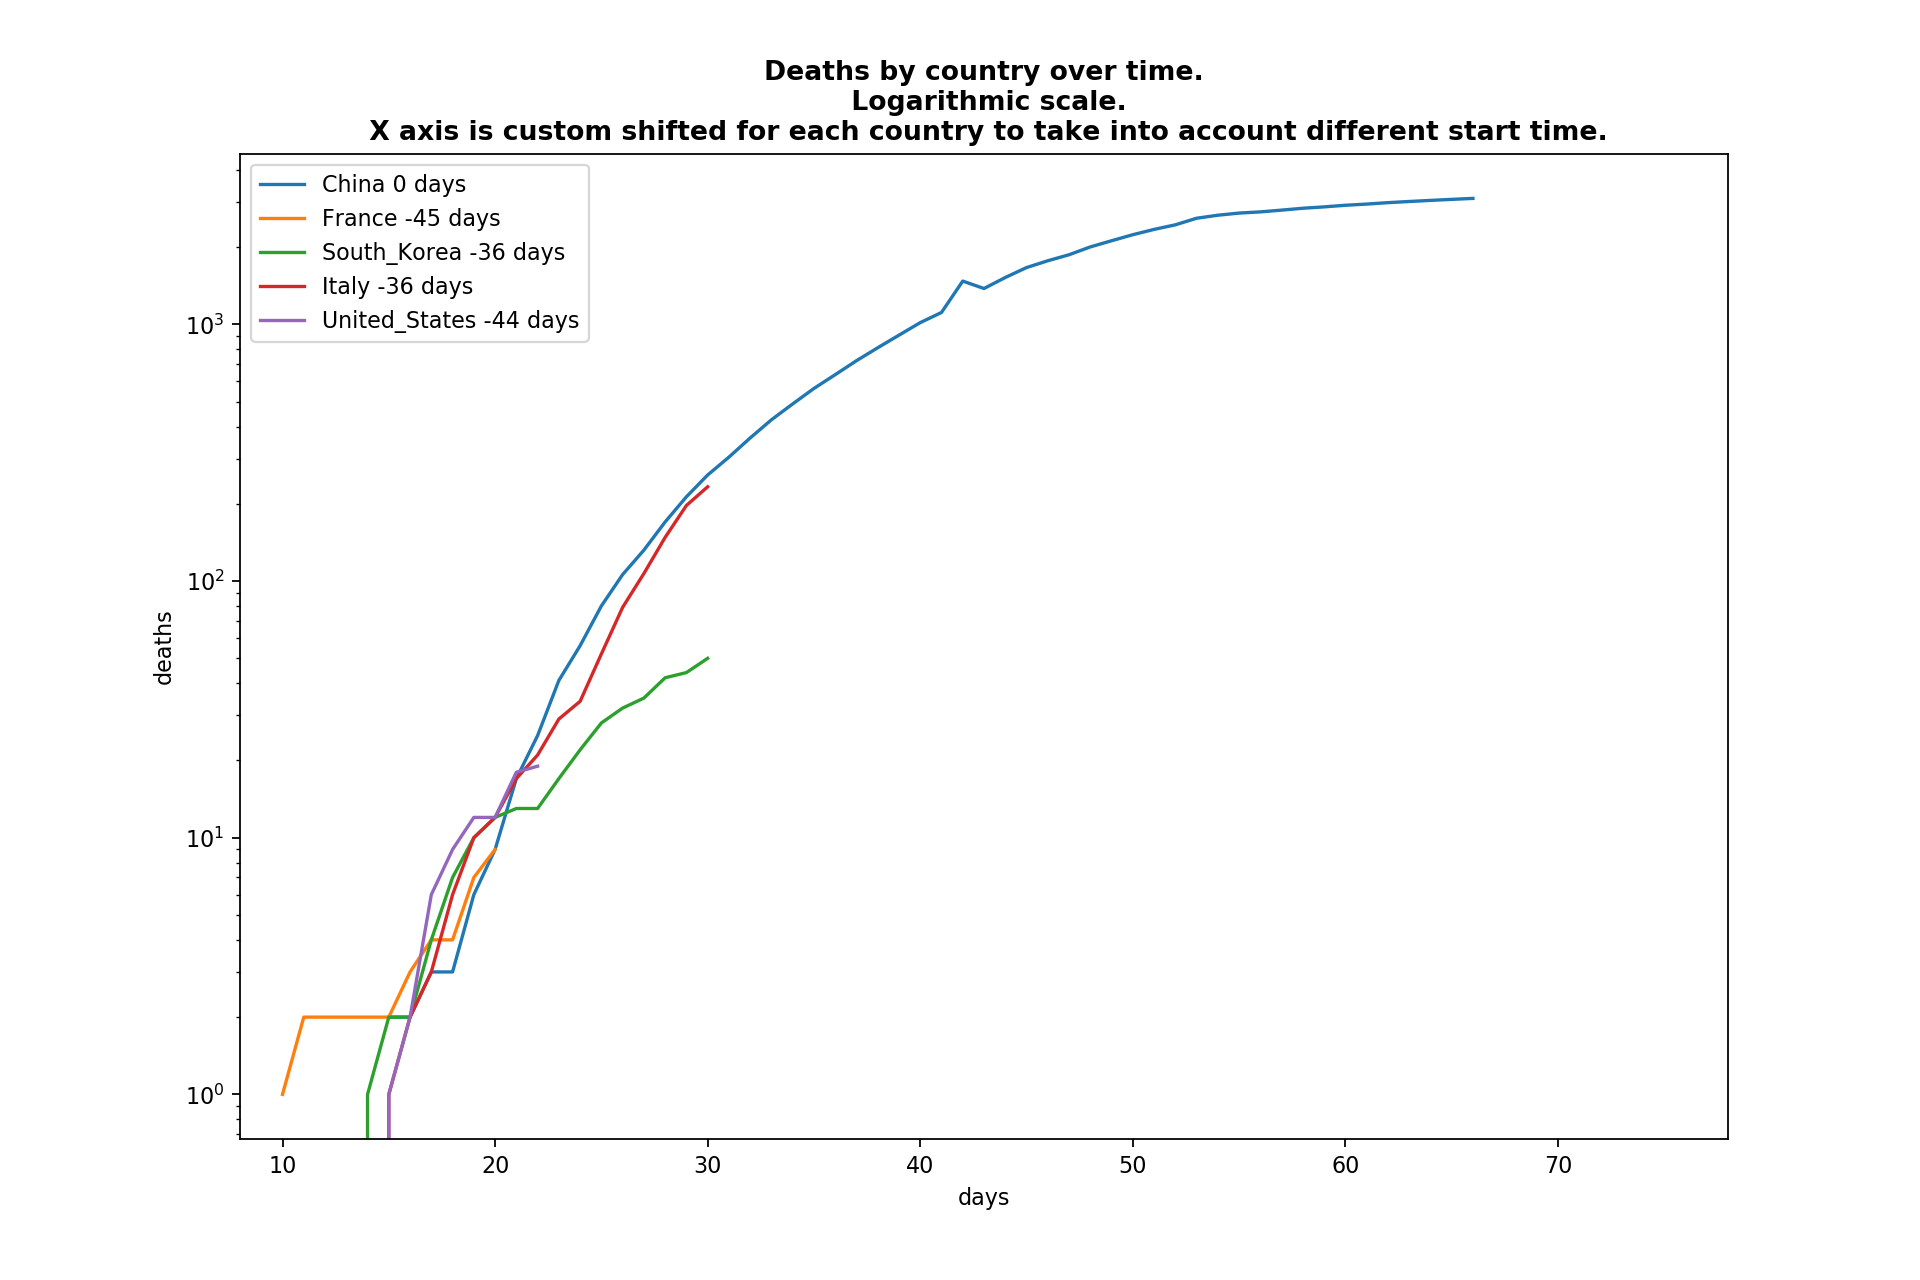

In [17]:
plot_comparison("deaths")

# Notes on number of deaths

## Time offsets
China obviously came first.
Italy and South Korea almost at the same time, 36 days later.
Then France and USA are roughly 9 days behind Italy and South Korea.
It's important to note this, as you can tell somehow what will happen to you by looking at the previous countries.

## South Korea
From the graphics, it looks like *South Korea* is doing quite well to limit the number of deaths.
It looks like too that there was at least two steps in the growth, one stabilizing at 12 deaths, and a second growth stabilizing at 44.

## Italy
The curve for *Italy* is much more worrying : no inflection is visible right now, the growth is still exponential.

## United States
It's a bit early to be sure of anything, but the curve clearly follow an exponential growth right now

## France
A first cluster appeared early, explaining the early start, and a second wave has started. Right now it's difficult to judge of the trend.



<IPython.core.display.Javascript object>


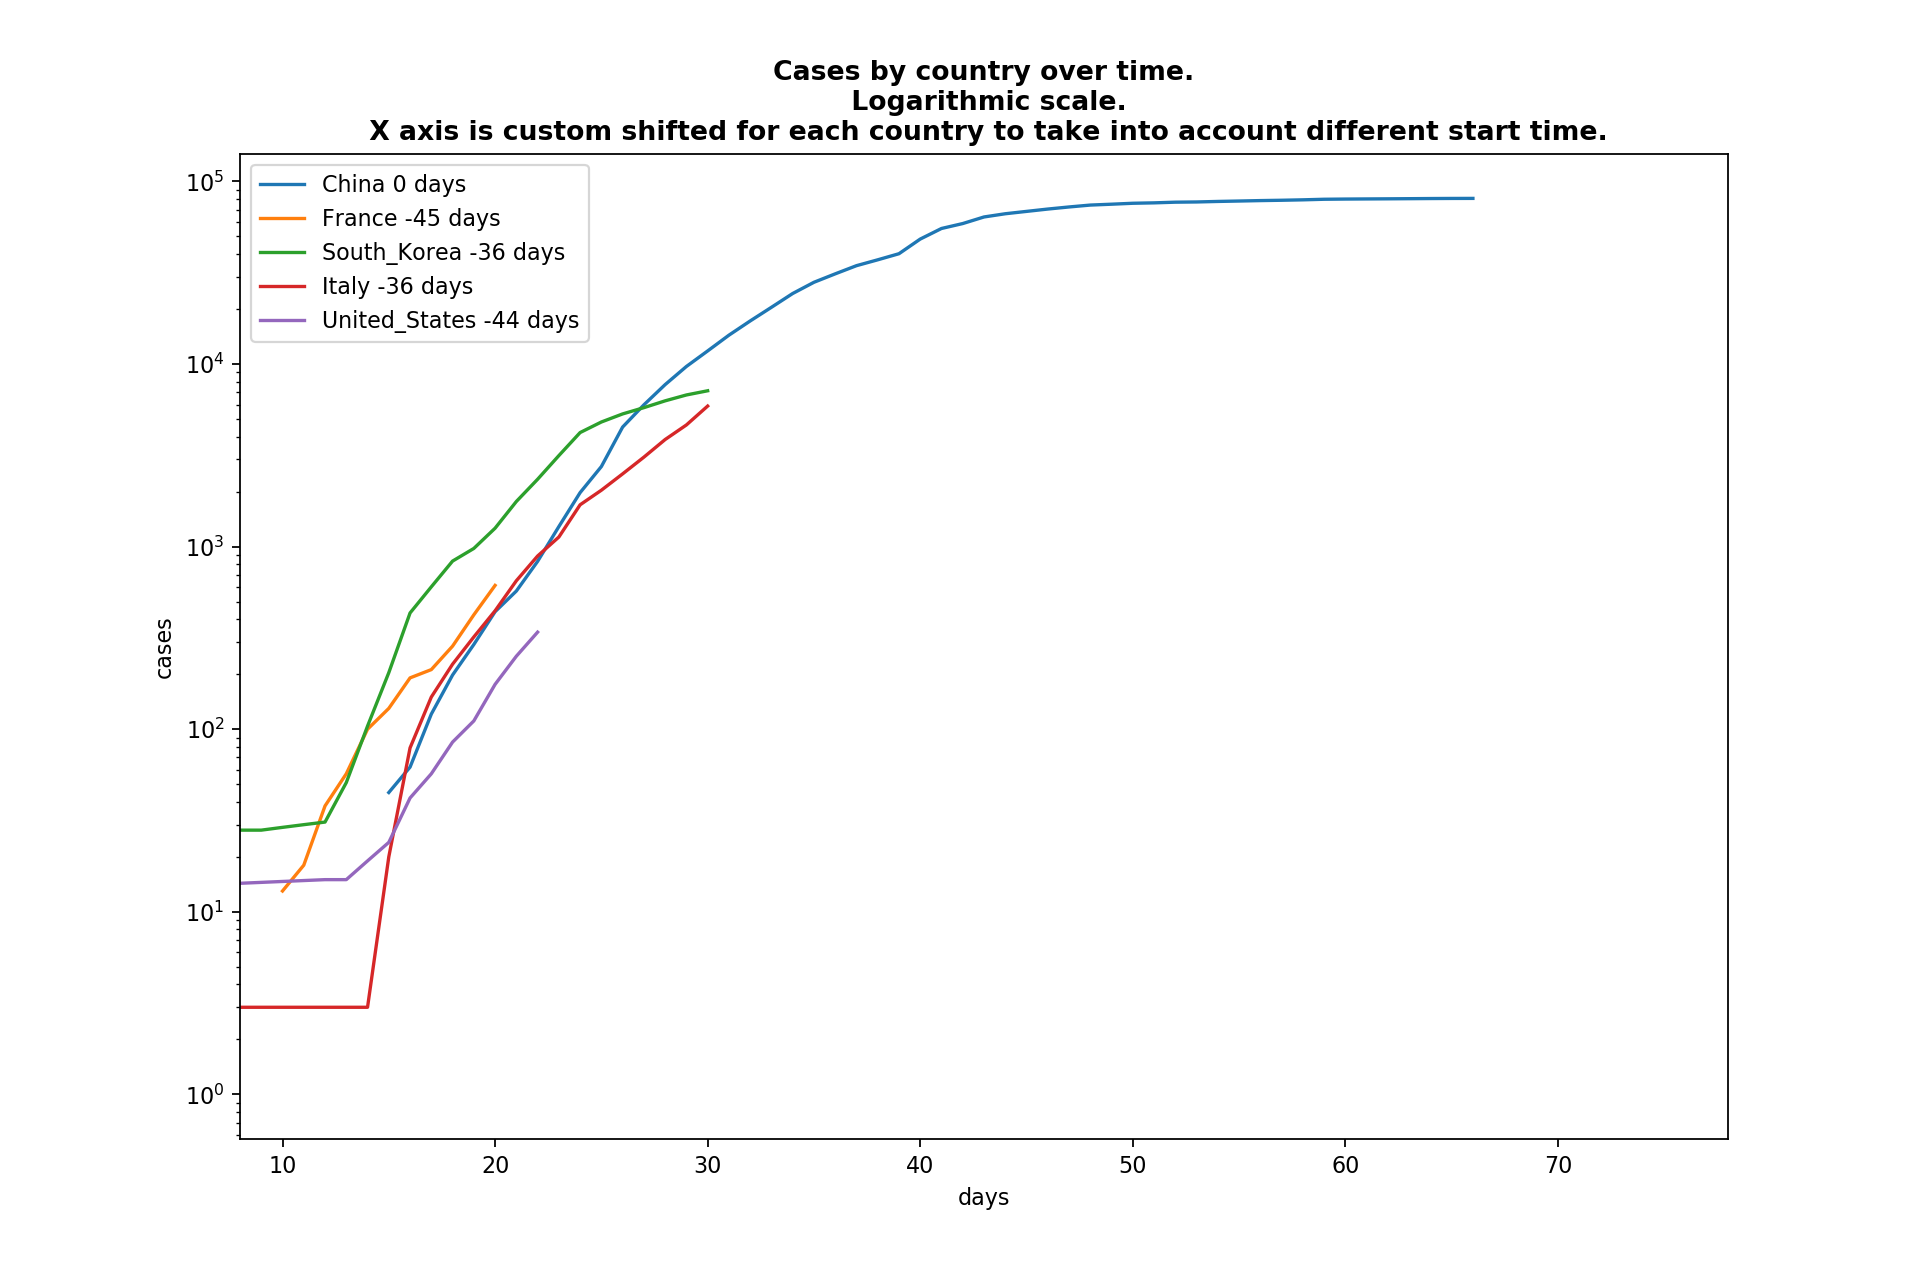

In [18]:
plot_comparison("cases")

# Notes on numbers of cases

We are using there the same time shifts we used for the deaths.
It's apparent that the different curves are separated.
My interpretation is that the testing policies of the different countries are very different, so you have to compensate for this (South Korea and Italy did a lot of tests).




